# Retrieving Data From HRRR
HRRR Data Availability: [https://registry.opendata.aws/noaa-hrrr-pds/]

Here, we will use the AWS CLI and subprocess library to execute commands
1. Download the AWS CLI: [https://docs.aws.amazon.com/cli/ladata/userguide/getting-started-install.html]
2. Find the location of the AWS CLI by running `where aws` in your terminal
3. Replace the `aws_path` variable below with your AWS CLI path

In [6]:
import subprocess
import pygrib
import matplotlib
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

In [2]:
# Replace with the full path to the AWS CLI executable
aws_path = r"C:\Program Files\Amazon\AWSCLIV2\aws.exe"  

# AWS command to list directories in the bucket
command = [aws_path, "s3", "ls", "s3://noaa-hrrr-bdp-pds/", "--no-sign-request"]

result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

if result.returncode == 0:
    print(result.stdout[:510] + '\n ...\n' + result.stdout[-521:])
else:
    print(f"Error: {result.stderr}")

                           PRE hrrr.20140730/
                           PRE hrrr.20140731/
                           PRE hrrr.20140801/
                           PRE hrrr.20140802/
                           PRE hrrr.20140803/
                           PRE hrrr.20140804/
                           PRE hrrr.20140805/
                           PRE hrrr.20140806/
                           PRE hrrr.20140807/
                           PRE hrrr.20140808/
                           PRE hrrr.20140809/
    
 ...
                           PRE hrrr_v2.20160815/
                           PRE hrrr_v2.20160816/
                           PRE hrrr_v2.20160817/
                           PRE hrrr_v2.20160818/
                           PRE hrrr_v2.20160819/
                           PRE hrrr_v2.20160820/
                           PRE hrrr_v2.20160821/
                           PRE hrrr_v2.20160822/
                           PRE hrrr_v2.20160823/
                           PRE nwges/
2021-

### Below are some example AWS CLI command executions to interact with the HRRR AWS database
- These commands may be used to sync all or some of the HRRR directory

In [3]:
# COMMENTED DUE TO LARGE DATASET SIZE AND LOAD TIME

# # AWS CLI command to sync a directory
# command = [
#     aws_path, "s3", "sync", 
#     "s3://noaa-hrrr-bdp-pds/hrrr.20210101/", 
#     "hrrr.20210101/",  # Destination directory on your local machine
#     "--no-sign-request"
# ]

# result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

In [4]:
# CLI command to check the diresctory size
command = [
    aws_path, "s3", "ls", 
    "s3://noaa-hrrr-bdp-pds/hrrr.20210101/", 
    "--no-sign-request", "--summarize", "--human-readable", "--recursive"
]


result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

if result.returncode == 0:
    print(result.stdout[-44:])
else:
    print(f"Error: {result.stderr}")  

Total Objects: 41264
   Total Size: 1.0 TiB



# HRRR Data Analysis with Pygrib
Installing `pygrib` is required to execute the following scripts
- See documentation [https://jswhit.github.io/pygrib]

In [5]:
# AWS CLI command to copy the first grib file in the dataset
command = [
    aws_path, "s3", "cp", 
    "s3://noaa-hrrr-bdp-pds/hrrr.20140730/conus/hrrr.t18z.wrfnatf00.grib2", 
    "hrrr.20210101/conus/hrrr.t18z.wrfnatf00.grib2",  # Destination directory on your local machine
    "--no-sign-request"
]

result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

In [7]:
# Open the GRIB2 file
grbs = pygrib.open('hrrr.20210101/conus/hrrr.t18z.wrfnatf00.grib2')

for grb in grbs:
    print(grb)

# Get the first GRIB message (grid)
grb = grbs[17]

# If you want specific grid details like latitudes and longitude
lat, lon = grb.latlons()
lat.min(), lat.max(), lon.min(), lon.max()

1:Maximum/Composite radar reflectivity:dB (instant):lambert:atmosphere:level 0 -:fcst time 0 hrs:from 201407301800
2:3:3 (instant):lambert:cloudTop:level 0:fcst time 0 hrs:from 201407301800
3:Vertically-integrated liquid:kg m**-1 (instant):lambert:atmosphere:level 0 -:fcst time 0 hrs:from 201407301800
4:Visibility:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201407301800
5:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 1000 m:fcst time 0 hrs:from 201407301800
6:Derived radar reflectivity:dB (instant):lambert:heightAboveGround:level 4000 m:fcst time 0 hrs:from 201407301800
7:Wind speed (gust):m s**-1 (instant):lambert:surface:level 0:fcst time 0 hrs:from 201407301800
8:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 0 hrs:from 201407301800
9:Temperature:K (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 0 hrs:from 201407301800
10:Dew point temperature:K (instant):lambert:isobaricInhPa:level 50000 Pa:fcst time 

(21.138, 52.61565399063001, -134.09612674048225, -60.91783900635959)

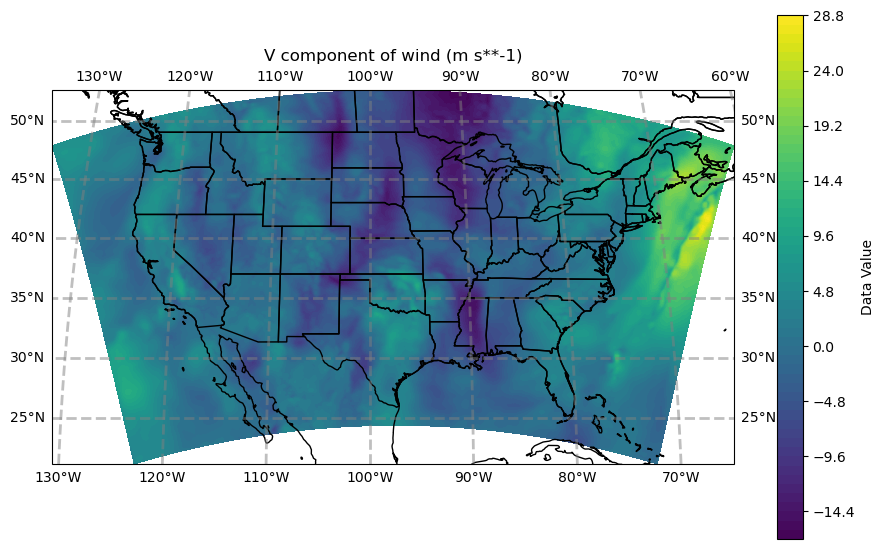

In [8]:
values, lats, lons = grb.data()

map_crs = ccrs.Robinson(central_longitude=260)

fig = plt.figure(figsize=(11, 8.5))

ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_title('%s (%s)' % (grb.name, grb.units))

ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

contour = ax.contourf(lons, lats, values, 60, transform=ccrs.PlateCarree())
fig.colorbar(contour, ax=ax, orientation='vertical', shrink=0.8, label='Data Value')

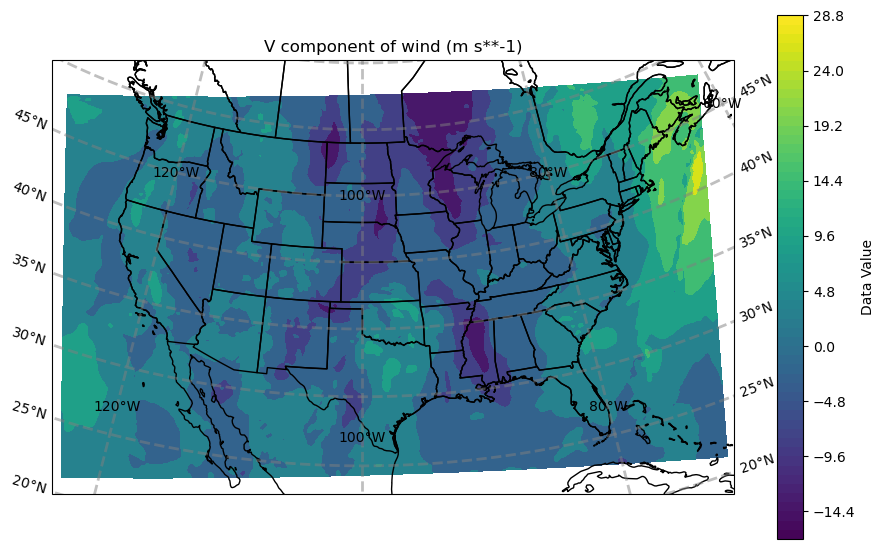

In [9]:
map_crs = ccrs.LambertConformal(central_longitude=260, central_latitude=35, standard_parallels=(30,60))

fig = plt.figure(figsize=(11, 8.5))

ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_title('%s (%s)' % (grb.name, grb.units))

ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([-124, -71, 23, 52], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

ax.contourf(lons, lats, values, transform=ccrs.PlateCarree())
fig.colorbar(contour, ax=ax, orientation='vertical', shrink=0.8, label='Data Value')

# Extracting Relevant HRRR data

In [10]:
# COMMENTED DUE TO LARGE DATASET SIZE AND LOAD TIME

# for date in dates:
#     # AWS CLI command to sync a directory
#     command = [
#         aws_path, "s3", "sync", 
#         f"s3://noaa-hrrr-bdp-pds/hrrr.{date}/", 
#         f"hrrr.{date}/",  # Destination directory on your local machine
#         "--no-sign-request"
#     ]

#     result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)